In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils import data

from skimage.io import imread
import os

import time
import matplotlib.pyplot as plt

from PIL import Image
import albumentations as A
import random
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset

In [ ]:
class SegmentationDataSet(data.Dataset):
    def __init__(self,
                 inputs: list,
                 images_root, 
                 targets_root,
                 transform=None
                 ):
        self.inputs = inputs
        self.images_root = images_root
        self.targets_root = targets_root
        self.transform = transform
        self.tensor_conversion = transforms.ToTensor()

        #self.inputs_dtype = torch.float32
        #self.targets_dtype = torch.long

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self,
                    index: int):
        # Select the sample
        input_ID = self.inputs[index]
        img_path = os.path.join(self.images_root, input_ID) #may need to add in .png at end
        img = cv2.imread(img_path,  cv2.IMREAD_GRAYSCALE)
        #Image.open(img_path).convert("L") #grayscale

        mask_path = os.path.join(self.targets_root, input_ID) 
        mask = cv2.imread(mask_path,  cv2.IMREAD_GRAYSCALE)#Image.open(mask_path).convert("L") #grayscale

        # Preprocessing
        if self.transform is not None:
            img, mask = self.transform(image=img, mask=mask)
            # mask = self.transform(mask)
        img = self.tensor_conversion(img)
        mask = self.tensor_conversion(mask)
        img = img/255
        mask = mask/255 #to normalize
        #x = torch.from_numpy(img)
        #y = torch.from_numpy(mask)

        # Typecasting
        #x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)

        return img, mask

In [ ]:
inps = os.listdir("/content/drive/MyDrive/APS360_Project/Dataset/t_image")
len(inps)

647

In [ ]:
train_aug = A.Compose([A.HorizontalFlip(p=0.5),  
    A.VerticalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)                  
        ], p=0.8),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8)],
    )

random.seed(11)

# transforms.Compose([transforms.PILToTensor()])
torch.manual_seed(0)
img_root ="/content/drive/MyDrive/APS360_Project/Dataset/t_image" #"/content/drive/MyDrive/APS360_Project/Dummy_data/images"
mask_root = "/content/drive/MyDrive/APS360_Project/Dataset/t_masked" # "/content/drive/MyDrive/APS360_Project/Dummy_data/masks"
# dset = SegmentationDataSet(inps, img_root, mask_root, train_aug)

In [ ]:
train_size = int( * len(inps)) #get size of train set
valid_size = len(dset) - train_size
train_dataset, valid_dataset = random_split(dset, [train_size, valid_size])

In [ ]:
print("Train set has: " , len(train_dataset)) 
print("Validation set has: ", len(valid_dataset))

Train set has:  2
Validation set has:  1


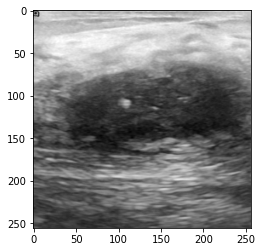

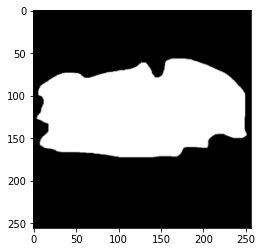

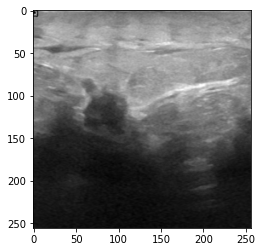

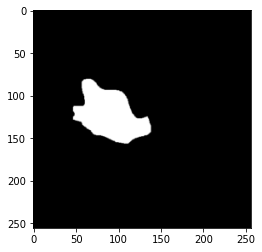

In [ ]:
sample_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, 
                                           num_workers=2, shuffle=True)
#visualize a training batch
# dataiter = iter(sample_train_loader)
# images, masks = dataiter.next()
# images = images.numpy() 
# masks = masks.numpy()

# Display image and label.
for train_features, train_labels in iter(sample_train_loader):
  img = train_features[0].squeeze()
  label = train_labels[0].squeeze()
  plt.imshow(img, cmap="gray")
  plt.show()
  plt.imshow(label, cmap="gray")
  plt.show()

# plt.imshow(label, cmap="gray")
# plt.show()
# train_features, train_labels = next(iter(sample_train_loader))
# # print(f"Feature batch shape: {train_features.size()}")
# # print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
# label = train_labels[0].squeeze()
# plt.imshow(img, cmap="gray")
# plt.show()

# plt.imshow(label, cmap="gray")
# plt.show()

#classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
# fig = plt.figure(figsize=(25, 4))
# for idx in np.arange(2):
#     #ax = fig.add_subplot(2, 2/2, idx+1, xticks=[], yticks=[])
#     plt.imshow(np.transpose(images[idx], (1, 2, 0)))
#     plt.imshow(np.transpose(masks[idx], (1, 2, 1)))
    #ax.set_title(classes[labels[idx]])

Model

In [ ]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3)
    
    def forward(self, x):
        return self.relu(self.conv2(self.relu(self.conv1(x))))

In [ ]:
# enc_block = Block(1, 64)
# x         = torch.randn(1, 1, 572, 572)
# enc_block(x).shape

# torch.Size([1, 64, 568, 568])

In [ ]:
class Encoder(nn.Module):
    def __init__(self, chs=(1,64,128,256,512,1024)):
        super().__init__()
        self.enc_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)])
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

In [ ]:
# encoder = Encoder()
# # input image
# x    = torch.randn(1, 1, 572, 572)
# ftrs = encoder(x)
# for ftr in ftrs: print(ftr.shape)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, chs=(1024, 512, 256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            enc_ftrs = self.crop(encoder_features[i], x)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

In [ ]:
# decoder = Decoder()
# x = torch.randn(1, 1024, 28, 28)
# decoder(x, ftrs[::-1][1:]).shape

# >> (torch.Size([1, 64, 388, 388])

In [ ]:
class UNet(nn.Module):
    def __init__(self, name, img_sz=(256,256), enc_chs=(1,64,128,256,512,1024), dec_chs=(1024, 512, 256, 128, 64), num_class=1, retain_dim=False):
        super().__init__()
        self.name = name
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim
        self.img_sz = img_sz

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        out      = self.head(out)
        if self.retain_dim:
            out = F.interpolate(out, self.img_sz)
        return out

In [ ]:
# unet = UNet(retain_dim=True, img_sz=(256,256))
# x    = torch.randn(1, 1, 256, 256)
# unet(x).shape

Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-6):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs) 
        #targets = targets/255      #normalize mask values
        # print(inputs.shape)
        # print(targets.shape)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        #dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        dice = (2.*intersection)/(inputs.sum() + targets.sum()) 
        # dice = (2.*intersection)/(len(inputs.shape) + len(targets) )
        
        # print(len(inputs)) 
       # print(targets.shape) 
        
        return 1 - dice

Train Loop

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
def train_net(net, train_dset, valid_dset, device, batch_size=64, learning_rate=0.001, num_epochs=30):
    """ Trains the network on  train_dset and measures performance on valid_set.

     Args:
         net: PyTorch neural network object
         train_dset: PyTorch training dataset
         vald_dset: Pytorch validation dataset
         device: the acceleration device (GPU or CPU)
         batch_size: the batch size (default 64)
         learning_rate: the learning rate (default 0.001)
         num_epochs: the total number of epochs over which to train (default 30)
     Returns:
         the model name (using get_model_name) of the epoch with the lowest validation loss (to get a rough idea of when the model starts overfitting )
     """
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = DataLoader(dataset=train_dset, shuffle=True, batch_size=batch_size, num_workers=4)
    val_loader = DataLoader(dataset=valid_dset, shuffle=False, batch_size=batch_size, num_workers=4)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss (CE). In this case we
    # will use the CrossEntropyLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be Adam.
    criterion = DiceLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

    ########################################################################
    # Set up some numpy arrays to store the training/validation loss/accuracy
    #train_accuracy = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    #val_accuracy = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    #initializing variables to track best epoch (for my convenience later when choosing a model to get an idea of roughly when the model starts overfitting)
     
    best_epoch = 0
    #best_epoch_val_accuracy = 0
    best_epoch_val_loss = 0 

    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_valid_loss = 0.0
        total_epoch = 0
        net.train()
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
             #To Enable GPU Usage (if GPU available, otherwise device = CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            # Calculate the statistics
            #corr = sum(torch.argmax(outputs,1) == labels) #number of correct predictions
            #total_train_accuracy += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        #train_accuracy[epoch] = float(total_train_accuracy) / total_epoch #training accuracy over epoch
        train_loss[epoch] = float(total_train_loss) / (i+1) #avg training loss
        #val_accuracy[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion, device) #get validation performance statistics
        current_lr = optimizer.state_dict()['param_groups'][0]['lr']
        net.eval()
        with torch.no_grad():
          for i, data in enumerate(val_loader, 0):
              # Get the inputs
              inputs, labels = data
              #To Enable GPU Usage (if GPU available, otherwise device = CPU)
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = net(inputs)
              #print(outputs.shape)
              #print(labels.shape)
              loss = criterion(outputs, labels)
              total_valid_loss += loss.item()
          val_loss[epoch] = float(total_valid_loss) / (i+1) #avg validation loss
        
        if epoch == 0: #if first epoch, initialize tracker values
          #best_epoch_val_accuracy = val_accuracy[epoch]
          best_epoch = epoch
          best_epoch_val_loss = val_loss[epoch]


        elif val_loss[epoch] < best_epoch_val_loss: #change to track the epoch with lowest validation loss
          best_epoch_val_loss = val_loss[epoch]
          #best_epoch_val_accuracy = val_accuracy[epoch]
          best_epoch = epoch
        print(("Epoch {}: , Train DiceLoss: {} |"+
               "Validation DiceLoss: {} | lr: {}").format(
                   epoch + 1,
                   #train_accuracy[epoch],
                   train_loss[epoch],
                  # val_accuracy[epoch],
                   val_loss[epoch],
                   current_lr))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    #np.savetxt("{}_train_accuracy.csv".format(model_path), train_accuracy)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    #np.savetxt("{}_val_accuracy.csv".format(model_path), val_accuracy)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print("Best Epoch Was: ", best_epoch)
    #print("Best Epoch Accuracy: ", best_epoch_val_accuracy)
    print("Best Epoch Loss: ", best_epoch_val_loss)
    
    #plot training curve
    plt.title("Train vs Validation Loss")
    n = len(train_loss) # number of epochs
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Loss (1 - Dice Score)")
    plt.legend(loc='best')
    plt.show()

    return get_model_name(net.name, batch_size, learning_rate, best_epoch)

**Training**

In [ ]:
from numba import cuda 

if torch.cuda.is_available():
  device = cuda.get_current_device()
  device.reset()


is_cuda = torch.cuda.is_available()

# Use GPU if available. device vairable will also be used later in the code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


GPU not available, CPU used


In [ ]:
model = UNet(name="toynet", retain_dim=True)
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1: , Train DiceLoss: 0.7175302505493164 |Validation DiceLoss: 0.597557544708252 | lr: 0.001
Epoch 2: , Train DiceLoss: 0.7159250974655151 |Validation DiceLoss: 0.5948153734207153 | lr: 0.0005
Epoch 3: , Train DiceLoss: 0.7143386602401733 |Validation DiceLoss: 0.5924475789070129 | lr: 0.001
Epoch 4: , Train DiceLoss: 0.7128830552101135 |Validation DiceLoss: 0.5862818956375122 | lr: 0.0008535533905932737
Epoch 5: , Train DiceLoss: 0.7090207934379578 |Validation DiceLoss: 0.5771526098251343 | lr: 0.0005
Epoch 6: , Train DiceLoss: 0.7034333944320679 |Validation DiceLoss: 0.5675279498100281 | lr: 0.00014644660940672628
Epoch 7: , Train DiceLoss: 0.6975603103637695 |Validation DiceLoss: 0.5632946491241455 | lr: 0.001
Epoch 8: , Train DiceLoss: 0.6949748992919922 |Validation DiceLoss: 0.49201709032058716 | lr: 0.0009619397662556434
Epoch 9: , Train DiceLoss: 0.657646894454956 |Validation DiceLoss: 0.49275726079940796 | lr: 0.0008535533905932737
Epoch 10: , Train DiceLoss: 0.643938481807

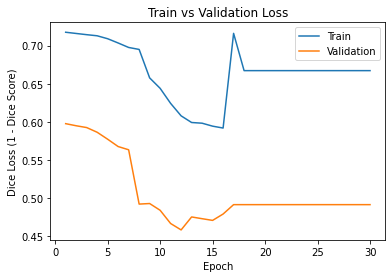

'model_toynet_bs2_lr0.001_epoch11'

In [ ]:
train_net(model, train_dataset, valid_dataset, device, batch_size=2, learning_rate=0.001, num_epochs=30)

In [ ]:
model_path = "/content/model_toynet_bs2_lr0.001_epoch11"#get_model_name(name="modeld", batch_size=128, learning_rate=0.001, epoch=36)
state = torch.load(model_path)
model.load_state_dict(state) #load weights of the best model onto the best model architecture
model.to(device)

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): Block(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      )
      (1): Block(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      )
      (2): Block(
        (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      )
      (3): Block(
        (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
      )
      (4): Block(
        (conv1): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
        (relu): ReLU()
        (conv2): Conv2d(1024, 1024, kernel_size=(3, 3), stride=(1, 1))
      )
    )
    

torch.Size([1, 1, 256, 256])
torch.Size([256, 256])


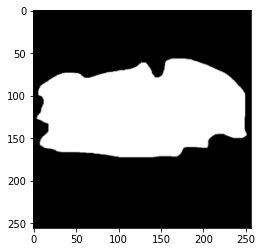

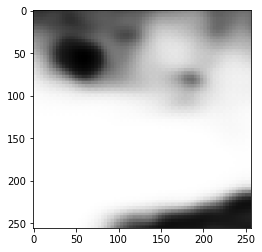

torch.Size([1, 1, 256, 256])
torch.Size([256, 256])


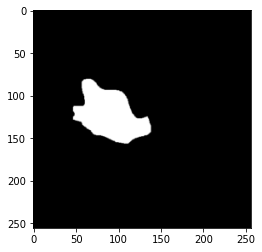

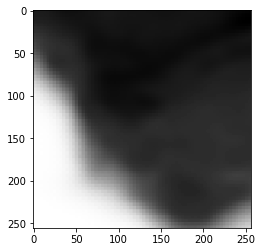

In [ ]:
for train_features, train_labels in iter(sample_train_loader):
  img = train_features[0]#.squeeze()
  label = train_labels[0].squeeze()
  img = torch.unsqueeze(img, dim=0)
  img = img.to(device)
  
  print(img.shape)
  output = model(img)
  output = F.sigmoid(output) 
  output = output.squeeze()
  # output = torch.unsqueeze(output, dim=0)
  print(output.shape)
  output = output.detach().numpy() * 255
  
  plt.imshow(label, cmap="gray")
  plt.show()
  plt.imshow(output, cmap="gray")
  plt.show()
# model()

torch.Size([1, 1, 256, 256])
torch.Size([256, 256])


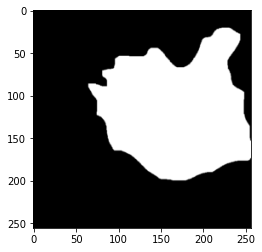

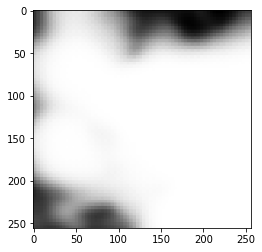

In [ ]:
sample_val_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, 
                                           num_workers=2, shuffle=True)
for train_features, train_labels in iter(sample_val_loader):
  img = train_features[0]#.squeeze()
  label = train_labels[0].squeeze()
  img = torch.unsqueeze(img, dim=0)
  img = img.to(device)
  
  print(img.shape)
  output = model(img)
  output = F.sigmoid(output) 
  output = output.squeeze()
  # output = torch.unsqueeze(output, dim=0)
  print(output.shape)
  output = output.detach().numpy() * 255
  
  plt.imshow(label, cmap="gray")
  plt.show()
  plt.imshow(output, cmap="gray")
  plt.show()
# model()